In this homework, we'll deploy the dino or dragon model we trained in the previous homework.

Download the model from here:

https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5

# Download the model 

In [1]:
import wget
downloaded_model = wget.download("https://github.com/SVizor42/ML_Zoomcamp/releases/download/dino-dragon-model/dino_dragon_10_0.899.h5")

100% [........................................................................] 89759168 / 89759168

In [2]:
downloaded_model

'dino_dragon_10_0.899.h5'

Now convert this model from Keras to TF-Lite format.

# Import Libraries

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

# Convert downloaded Keras model to TFlite model

In [5]:
model = keras.models.load_model('./dino_dragon_10_0.899.h5')

In [6]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open("dino-dragon-model.tflite", "wb") as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Praveen\AppData\Local\Temp\tmp12z2i6p3\assets


## Question 1

What's the size of the converted model?

- 21 Mb
- **43 Mb**
- 80 Mb
- 164 Mb

In [7]:
import os
os.listdir()

['.ipynb_checkpoints',
 'convert_keras_to_tflite.py',
 'dino-dragon-model.tflite',
 'dino_dragon_10_0.899.h5',
 'Dockerfile',
 'Homework.ipynb',
 'lambda_function.py',
 'test-aws-lambda.py',
 'test-local.py']

In [8]:
print("dino-dragon-model.tflite: ", os.path.getsize("dino-dragon-model.tflite")/(1024*1024),"MB")  

dino-dragon-model.tflite:  42.78742599487305 MB


## Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

- 3
- 7
- **13**
- 24

In [9]:
import tensorflow.lite as tflite

In [10]:
interpreter = tflite.Interpreter("dino-dragon-model.tflite")
interpreter.allocate_tensors()

In [11]:
interpreter.get_input_details()

[{'name': 'serving_default_conv2d_input:0',
  'index': 0,
  'shape': array([  1, 150, 150,   3]),
  'shape_signature': array([ -1, 150, 150,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [12]:
input_index = interpreter.get_input_details()[0].get("index")
input_index

0

In [13]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 13,
  'shape': array([1, 1]),
  'shape_signature': array([-1,  1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [14]:
output_index = interpreter.get_output_details()[0].get("index")
output_index

13

# Preparing the image

***You'll need some code for downloading and resizing images. For that, you'll need to have pillow installed:***<br> 
**You can use this code:**

In [15]:
!pip install pillow

In [16]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

***Let's download and resize this image:***<br>
https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg


In [17]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/df/Smaug_par_David_Demaret.jpg/1280px-Smaug_par_David_Demaret.jpg"

Based on the previous homework, what should be the target size for the image?

In [18]:
target_size = (150, 150)

In [19]:
img = prepare_image(img=download_image(url), target_size= target_size)

C:\Users\Praveen\AppData\Local\Temp\ipykernel_34048\2487457277.py:17: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize(target_size, Image.NEAREST)


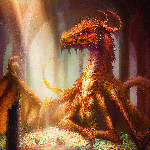

In [20]:
img

## Question 3

Now we need to turn the image into numpy array and pre-process it.

    Tip: Check the previous homework. What was the pre-processing we did there?

After the pre-processing, what's the value in the first pixel, the R channel?

- 0.3353411
- **0.5529412**
- 0.7458824
- 0.9654902

In [21]:
x = np.asarray(img)
X = np.array([x/255.], dtype="float32")
X.shape

(1, 150, 150, 3)

In [22]:
X[0][0][0][0] # X[0th element of array][0th row of image] [0th column][0] = 1st pixel's Red channel's value

0.5529412

## Question 4

Now let's apply this model to this image. What's the output of the model?

- 0.17049132
- 0.39009996
- 0.60146114
- **0.82448614**

In [23]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()

preds = interpreter.get_tensor(output_index)
preds[0][0] # Since the predicted value is closer to 1 it is a dragon

0.8244865

Prediction: Dragon


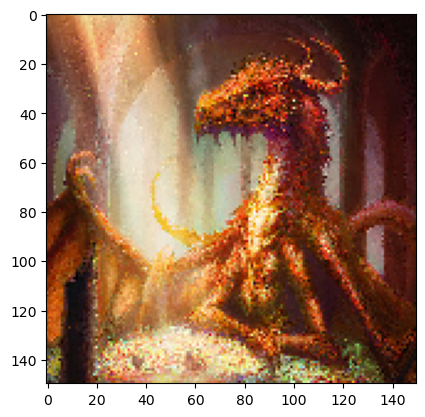

In [24]:
if (preds[0][0]>0.5):
    print("Prediction: Dragon")
    plt.imshow(x)
else:
    print("Prediction: Dino")
    plt.imshow(x)

# Prepare the lambda code

***Now you need to copy all the code into a separate python file. You will need to use this file for the next two questions.*** <br>

**Tip: you can test this file locally with ipython or Jupyter Notebook by importing the file and invoking the function from this file.**

### Docker

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

FROM public.ecr.aws/lambda/python:3.9 <br>
COPY dino-vs-dragon-v2.tflite .

    Note that the version of Python is 3.9, so you need to use the right wheel for TF-Lite. 
    For Tensorflow 2.7.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.7.0-cp39-cp39-linux_x86_64.whl

And pushed it to svizor42/zoomcamp-dino-dragon-lambda:v2.

    Note: The image already contains a model and it's not the same model as the one we used for questions 1-4.

## Question 5

Download the base image svizor42/zoomcamp-dino-dragon-lambda:v2. You can easily make it by using docker pull command.

So what's the size of this base image?

- 139 Mb
- 329 Mb
- **639 Mb**
- 929 Mb

***You can get this information when running docker images - it'll be in the "SIZE" column.***

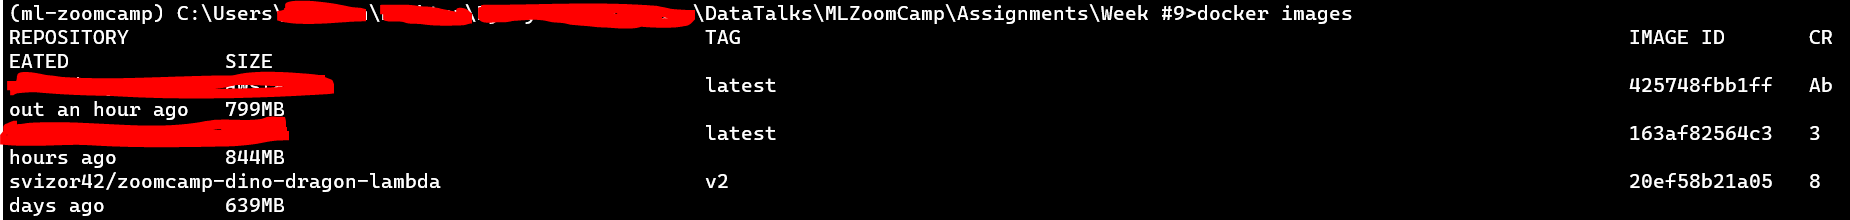  

## Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

You don't need to include the model in the image. It's already included. The name of the file with the model is dino-vs-dragon-v2.tflite and it's in the current workdir in the image (see the Dockerfile above for the reference).

Now run the container locally.

Score this image: https://upload.wikimedia.org/wikipedia/en/e/e9/GodzillaEncounterModel.jpg

What's the output from the model?

- 0.12
- **0.32**
- 0.52
- 0.72

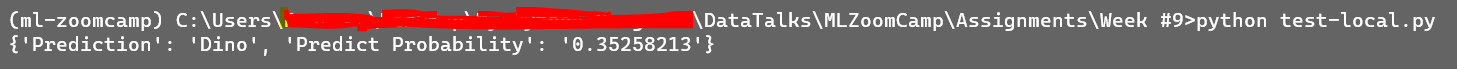